# Microsoft Movie Studio Business Analysis

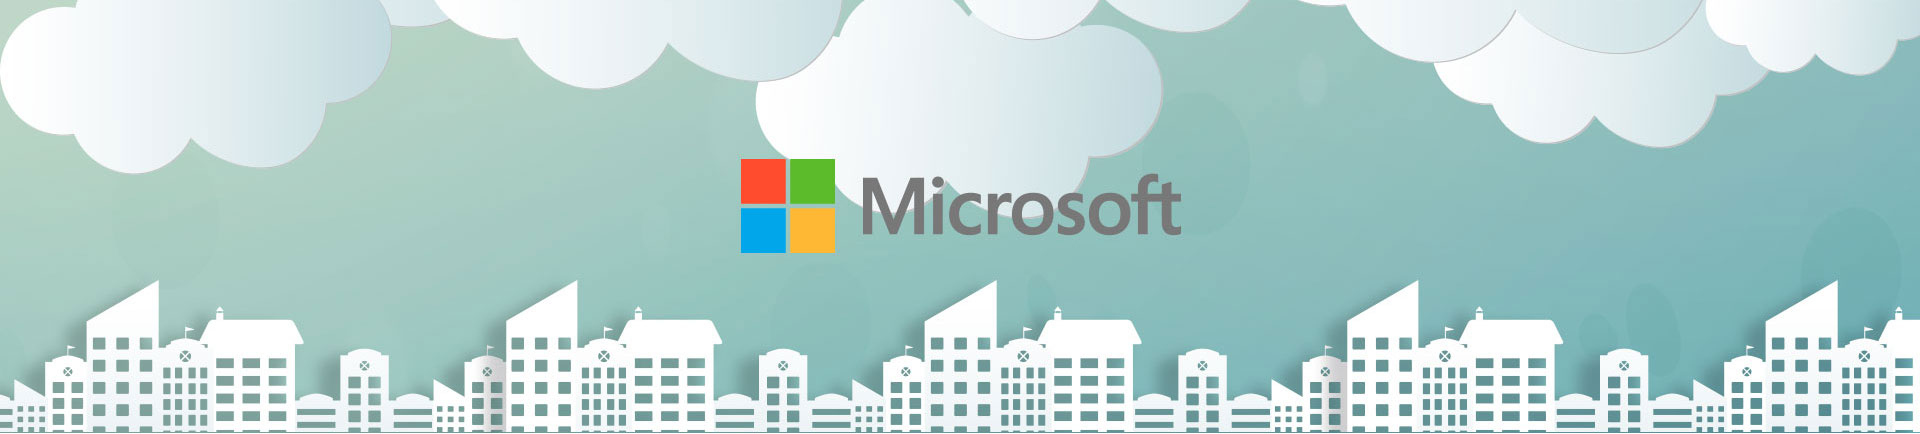

## Overview

Microsoft wants to launch a new movie studio, and there are important factors to consider for optimizing profits.

By analyzing historical data, we uncovered data-driven tips for ensuring a production is high performing with an efficient return on investment.

## Business Problem

Microsoft is diving into a new business — creating a film studio.

Unknown factors to achieving success.

Using the data provided and additional resources, we can devise a plan on how best Microsoft can break into the movie studio market and ensure profitability.

## Data Understanding

We are using movie datasets from 5 different sources:

 - IMDb
 - ROTTEN TOMATOES
 - TheMovieDB
 - Box Office Mojo
 - The Numbers

The data includes information on movie genres, titles, runtime, production expense, foreign & domestic box office gross, production studio name, and release dates.

With these datasets, we will search for insights in box office performence and user ratings compared to various factors like genre, personel, runtime, production budget and release time.

In [1]:
import pandas as pd
import numpy as np

In [2]:
box_mojo_df = pd.read_csv('data/bom.movie_gross.csv')
numbers_df = pd.read_csv('data/tn.movie_budgets.csv')
title_basics_df = pd.read_csv('data/imdb.title.basics.csv')
name_basics_df = pd.read_csv('data/imdb.name.basics.csv')
crew_df = pd.read_csv('data/imdb.title.crew.csv')
principal_df = pd.read_csv('data/imdb.title.principals.csv')
ratings_df = pd.read_csv('data/imdb.title.ratings.csv')
tmdb_df = pd.read_csv('data/tmdb.movies.csv')

## Data Preparation

Out of the available datasets, Imdb is the largest, with useful data on runtime, genres, and personnel. It's also more convenient to select which of these values we'd like to look at, as each data set has a `tconst` column that allows them to be stiched together. Unfortunately, Imdb lacks box office or budget data, so it needs to be merged with either The Numbers data set, or the Watch Mojo one. These three collectively are the most useful and what we'll be basing our recommendations on.

### Data Cleaning

In [3]:
# Organizing the imdb data for runtime analysis. Extracts columns needed to merge and the runtime data.
tb_df = title_basics_df[['primary_title', 'start_year', 'runtime_minutes']]
# Filter out movies that haven't been made yet, and those we don't have runtime data for.
tb_df = tb_df[tb_df['start_year'] < 2022]
tb_df = tb_df.dropna(axis=0, subset=['runtime_minutes'])
tb_df.head()

,primary_title,start_year,runtime_minutes
0,Sunghursh,2013,175.0
1,One Day Before the Rainy Season,2019,114.0
2,The Other Side of the Wind,2018,122.0
4,The Wandering Soap Opera,2017,80.0
5,A Thin Life,2018,75.0


In [4]:
# We change the year data to match the IMDB format of only the year number.
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])
numbers_df['release_year'] = numbers_df['release_date'].dt.year
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'])
tmdb_df['release_year'] = tmdb_df['release_date'].dt.year
# Create a Month DateTime column of the release dates
numbers_df['month_dt'] = pd.to_datetime(numbers_df['release_date']).dt.month
# Create a Month string column of the release dates
numbers_df['month'] = numbers_df['release_date'].dt.month
numbers_df = numbers_df.drop('release_date', 1)

In [5]:
# Converting to integer types for visualizations later
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
numbers_df[cols] = numbers_df[cols].replace('[\$,]', '', regex=True).astype('int64')

In [6]:
# Title case all title data to have a better chance of matching in the merge.
tb_df['primary_title'] = tb_df['primary_title'].str.title()
numbers_df['movie'] = numbers_df['movie'].str.title()
box_mojo_df['title'] = box_mojo_df['title'].str.title()
tmdb_df['title'] = tmdb_df['title'].str.title()

In [7]:
# Adding profit margin columns
numbers_df['dom_profit_margin'] = (numbers_df['domestic_gross'] - numbers_df['production_budget']) / numbers_df['domestic_gross'] * 100 
numbers_df['ww_profit_margin'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget']) / numbers_df['worldwide_gross'] * 100

In [8]:
# Adding a column 'world_wide_profit_amount' that is the worldwide gross minus the production budget
numbers_df['world_wide_profit_amount'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget'])

# Adding a ROI column that is the net profit amount divided by production budget. ROI = net / expense 
numbers_df['ROI_perc'] = (numbers_df['world_wide_profit_amount']  / numbers_df['production_budget']) * 100

In [9]:
# Making numbers_df only the years after 2000
numbers_df = numbers_df[numbers_df['release_year'] > 2000]

In [10]:
# Create a new data frame grouped by months and their median values.
month_df = numbers_df.groupby('month').median()

# Reset the index
month_df = month_df.reset_index()

# Sort the months in order
month_df = month_df.sort_values('month_dt')

# Add the names of the month
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', \
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_df['month_name'] = month_dict.values() 

numbers_df.sort_values('release_year')

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
1209,10,The One,49000000,43905746,72689126,2001,11,11,-11.602705,32.589642,23689126,48.345155
352,53,Town & Country,105000000,6712451,10364769,2001,4,4,-1464.257229,-913.047179,-94635231,-90.128791
2299,100,Say It Isn'T So,25000000,5516708,5516708,2001,3,3,-353.168810,-353.168810,-19483292,-77.933168
344,45,Ali,109000000,58183966,87683966,2001,12,12,-87.336834,-24.310071,-21316034,-19.555994
342,43,The Lord Of The Rings: The Fellowship Of The Ring,109000000,315544750,887210985,2001,12,12,65.456564,87.714309,778210985,713.955032
...,...,...,...,...,...,...,...,...,...,...,...,...
671,72,355,75000000,0,0,2019,12,12,-inf,-inf,-75000000,-100.000000
121,22,Dumbo,170000000,113883318,345004422,2019,3,3,-49.275595,50.725269,175004422,102.943778
194,95,Moonfall,150000000,0,0,2020,12,12,-inf,-inf,-150000000,-100.000000
535,36,Call Of The Wild,82000000,0,0,2020,2,2,-inf,-inf,-82000000,-100.000000


### Merging Datasets

Merging The Numbers data set and Imdb for runtime and box office gross comparisons.

In [11]:
# Merge on title and year to avoid incorrect matches on movies that have the same name.
numbers_and_tb = numbers_df.merge(tb_df,left_on=['movie', 'release_year'],right_on=['primary_title', 'start_year'],how='inner')
numbers_and_tb = numbers_and_tb.loc[numbers_and_tb['domestic_gross'] > 0]

In [12]:
new_movie = box_mojo_df[['title', 'studio', 'year']].merge(numbers_df, left_on=['title', 'year'], right_on=['movie', 'release_year'])

In [13]:
avg_studio = new_movie.groupby('studio').mean().reset_index()
avg_studio = avg_studio[avg_studio['dom_profit_margin'] > 0]

In [14]:
# Merge The Numbers and Tmdb to get box office and budget together with genres
genre_df = numbers_df.merge(tmdb_df, left_on=['movie', 'release_year'], right_on=['title', 'release_year'])
genre_df.loc[:,'genre_ids'] = genre_df['genre_ids'].map(lambda genre_string: genre_string.strip('[]').split(', '))
genre_df = genre_df.loc[(genre_df['worldwide_gross'] > 0) & (genre_df['domestic_gross'] > 0)]
genre_ids_df = genre_df.explode('genre_ids')

# genre key for ids in Tmdb
genre_converter = pd.read_csv('genre_list.csv')
genre_converter['id'] = genre_converter['id'].astype('str')
genre_converter.rename(columns={"id": "genre_ids", "name": "genre_name"}, inplace=True)
genre_overall = genre_ids_df.merge(genre_converter, on="genre_ids")
genre_overall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4132
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_x                      4133 non-null   int64         
 1   movie                     4133 non-null   object        
 2   production_budget         4133 non-null   int64         
 3   domestic_gross            4133 non-null   int64         
 4   worldwide_gross           4133 non-null   int64         
 5   release_year              4133 non-null   int64         
 6   month_dt                  4133 non-null   int64         
 7   month                     4133 non-null   int64         
 8   dom_profit_margin         4133 non-null   float64       
 9   ww_profit_margin          4133 non-null   float64       
 10  world_wide_profit_amount  4133 non-null   int64         
 11  ROI_perc                  4133 non-null   float64       
 12  Unnamed: 0          

In [15]:
genre_groups = genre_overall.groupby('genre_name').mean()
genre_groups = genre_groups.sort_values('ROI_perc', ascending=False)[:7]

In [16]:
genre_groups_med = genre_overall.groupby('genre_name').median()
genre_groups_med = genre_groups_med.sort_values('ROI_perc', ascending=False)[:7]

In [17]:
horror_month_df = genre_overall[genre_overall['genre_name'] == 'Horror']
horror_month_df = horror_month_df[horror_month_df['worldwide_gross'] > 100000]
horror_month_df = horror_month_df.groupby('month').median()
horror_month_df = horror_month_df.reset_index()
horror_month_df = horror_month_df.sort_values('month_dt')
horror_month_df['month_name'] = month_dict.values() 
horror_month_df

,month,id_x,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc,Unnamed: 0,id_y,popularity,vote_average,vote_count,month_name
0,1,50.0,12500000.0,33694789.0,77892256.0,2014.0,1.0,59.077100,76.505732,57821755.0,325.677601,11158.0,135635.0,10.8860,5.50,1042.0,Jan
1,2,72.0,10000000.0,26797294.0,48461873.5,2014.0,2.0,64.748648,80.452977,36954520.0,475.462447,11116.0,78689.5,12.6105,6.10,1115.5,Feb
2,3,70.0,5000000.0,14674077.0,23250755.0,2015.0,3.0,73.648329,83.311110,21250755.0,499.201020,14212.0,270303.0,13.3100,6.20,1282.0,Mar
3,4,59.0,5000000.0,35485286.5,67527083.0,2013.5,4.0,56.584123,75.704522,40689968.0,333.270935,9621.0,133487.5,10.3920,6.30,1678.5,Apr
4,5,29.0,35000000.0,29136626.0,84154026.0,2015.0,5.0,-30.618566,59.332763,41411721.0,145.898193,14217.0,126889.0,15.2590,5.30,1157.0,May
5,6,65.0,11500000.0,49595539.5,105015011.5,2016.0,6.0,35.177750,69.449197,79128155.5,237.074306,17491.5,291700.0,14.3365,6.25,2764.0,Jun
6,7,52.0,11000000.0,48922978.5,99745749.5,2015.5,7.0,86.396271,91.746503,80245749.5,1112.211863,15934.5,307986.0,15.1345,6.10,1475.0,Jul
7,8,55.0,16000000.0,33613164.5,75795444.0,2012.5,8.0,54.699539,78.051999,56560843.5,362.180690,6696.0,81796.5,11.3760,5.85,1085.5,Aug
8,9,38.0,10000000.0,20777061.0,38985577.0,2016.0,9.0,4.371576,69.645511,21517819.0,229.440564,17580.0,298312.0,9.7720,5.70,1033.0,Sep
9,10,58.0,10000000.0,35144505.0,81831866.0,2014.0,10.0,25.049234,63.596439,67959374.0,174.698400,11091.0,201085.0,13.1020,6.00,1404.0,Oct


## Analysis

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

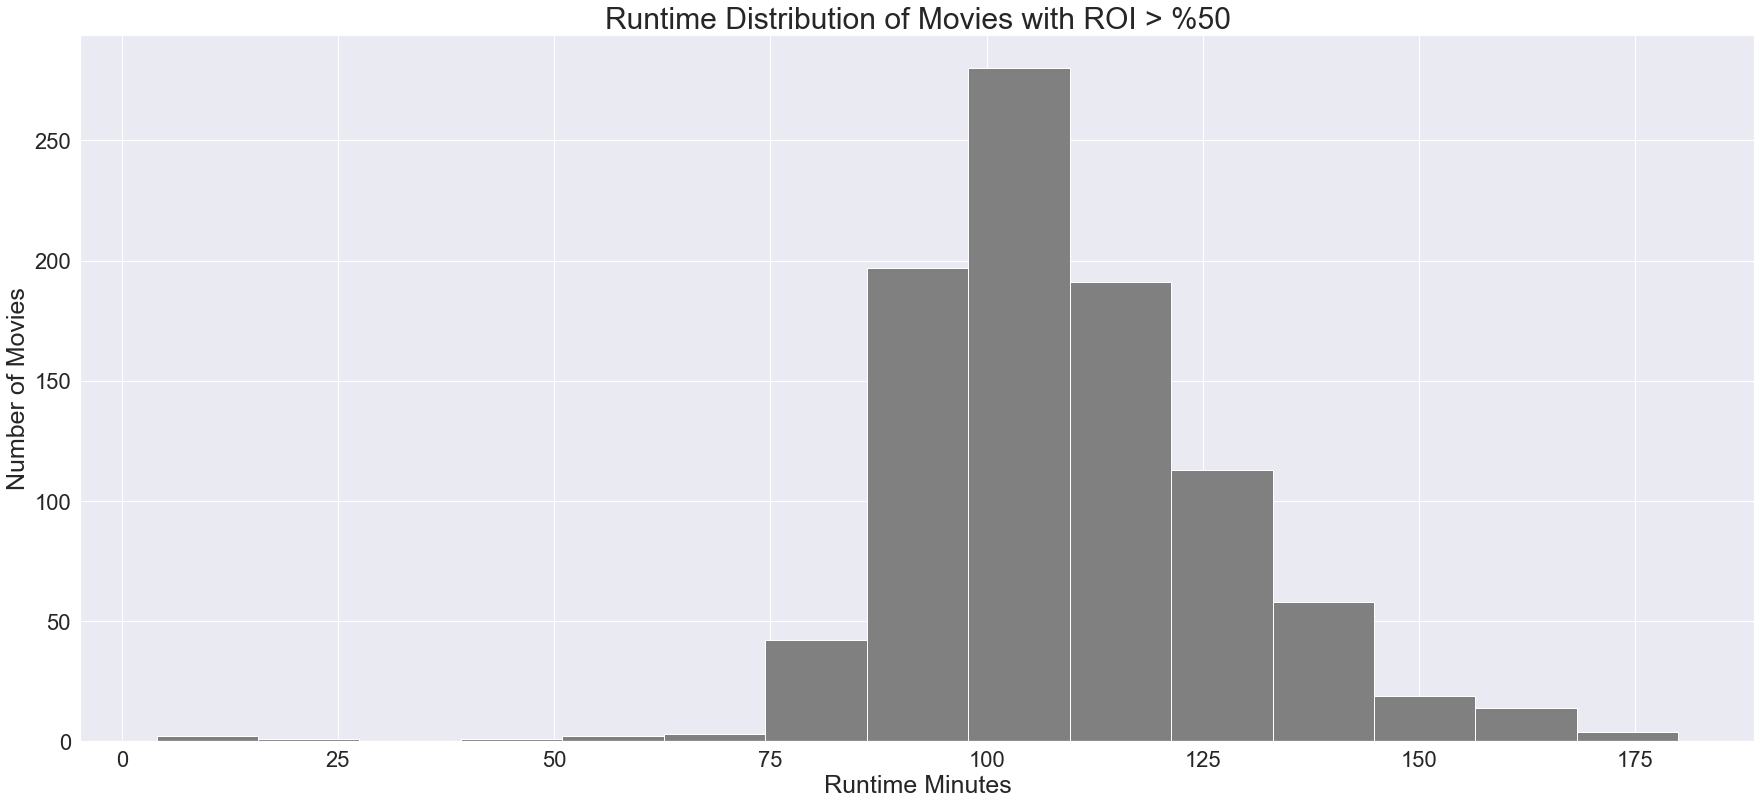

In [42]:
fig, ax = plt.subplots(figsize=(30,13))


ax.hist(numbers_and_tb['runtime_minutes'].loc[(numbers_and_tb['runtime_minutes'] < 250) & (numbers_and_tb['ROI_perc'] > 50)], bins=15, color='grey')

ax.tick_params(axis="x")
ax.set_xlabel("Runtime Minutes", fontsize=25)
ax.set_ylabel("Number of Movies", fontsize=25)
ax.set_title("Runtime Distribution of Movies with ROI > %50", fontsize=30);

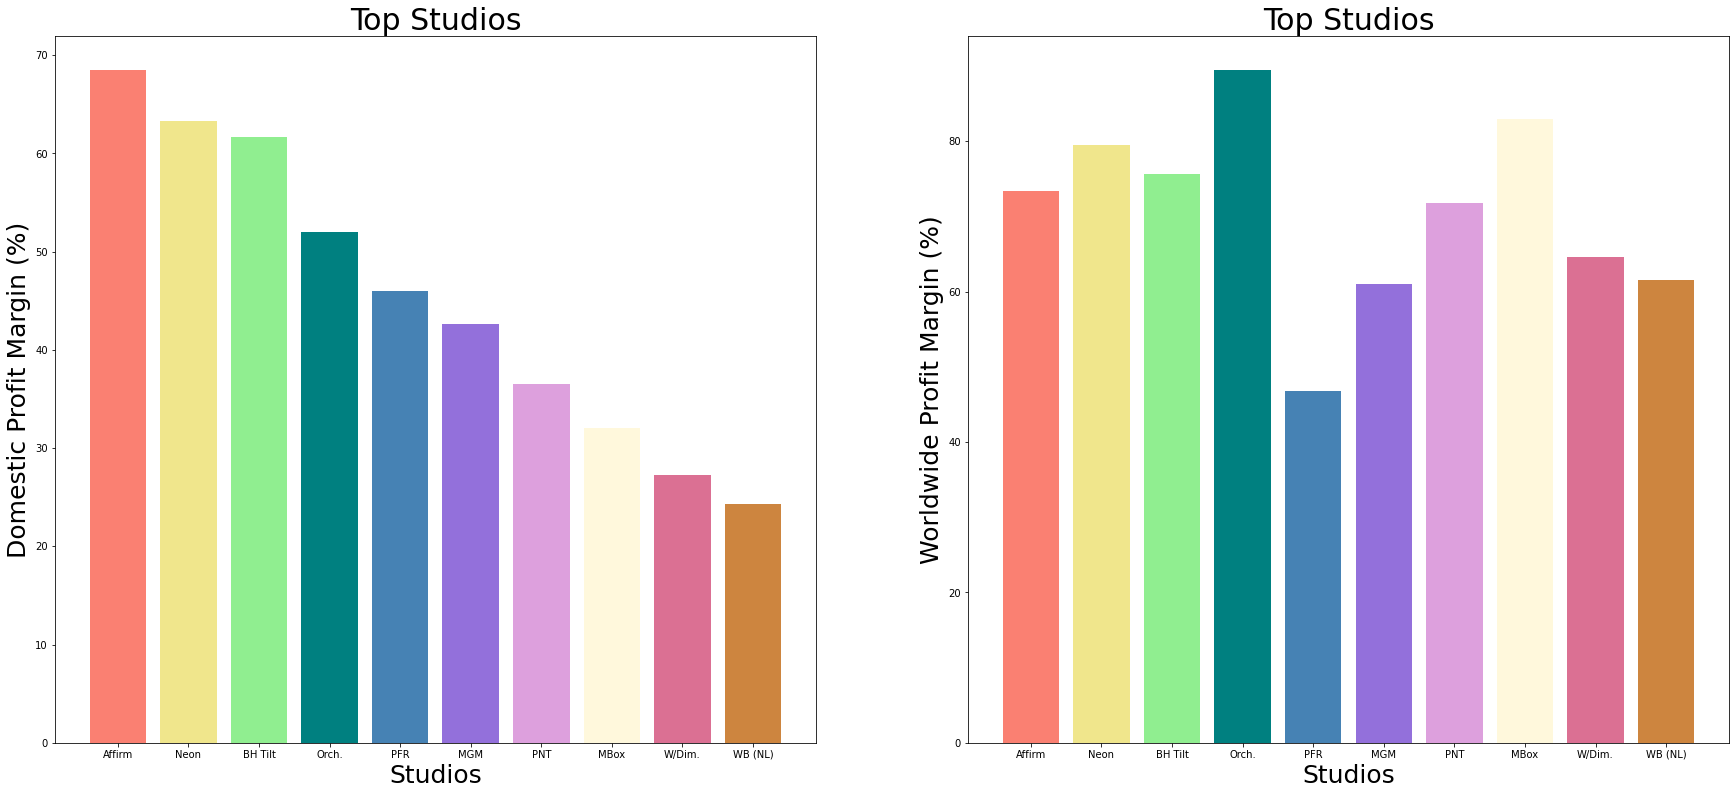

In [20]:
avg_studio = avg_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, axs= plt.subplots(figsize=(30,13), ncols=2)

axs[0].bar(avg_studio['studio'], avg_studio['dom_profit_margin'],
          color=['salmon', 'khaki', 'lightgreen', 'teal', 'steelblue', 'mediumpurple', 'plum', 'cornsilk', 'palevioletred', 'peru'])
axs[1].bar(avg_studio['studio'], avg_studio['ww_profit_margin'],
          color=['salmon', 'khaki', 'lightgreen', 'teal', 'steelblue', 'mediumpurple', 'plum', 'cornsilk', 'palevioletred', 'peru'])

axs[0].set_title('Top Studios', fontsize=30)
axs[0].set_xlabel('Studios', fontsize=25)
axs[0].set_ylabel('Domestic Profit Margin (%)', fontsize=25)

axs[1].set_title('Top Studios', fontsize=30)
axs[1].set_xlabel('Studios', fontsize=25)
axs[1].set_ylabel('Worldwide Profit Margin (%)', fontsize=25);

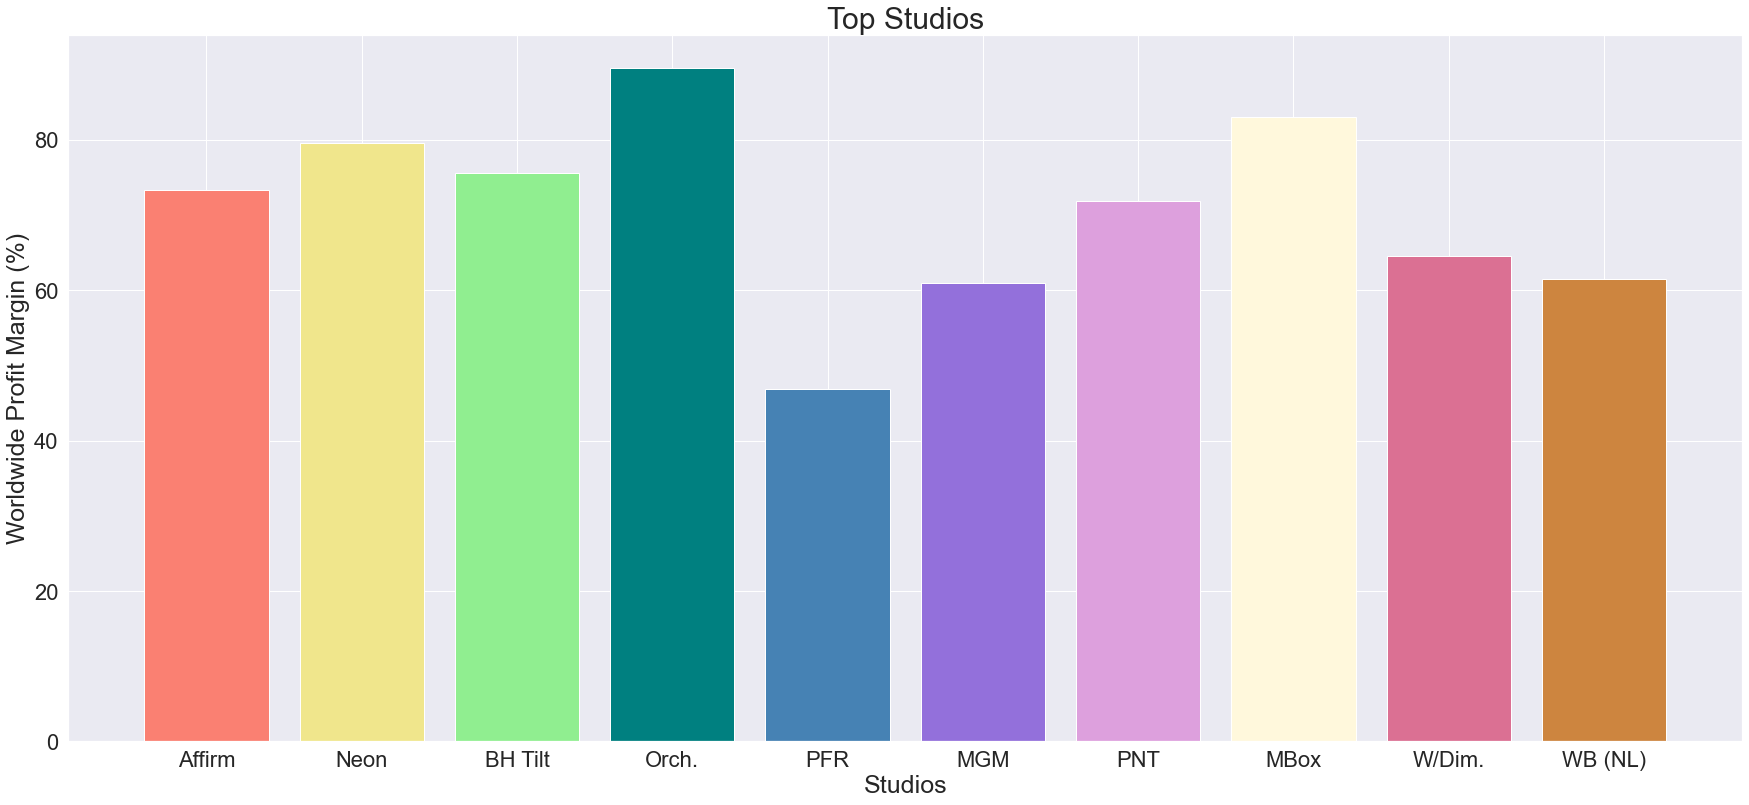

In [40]:
fig, ax= plt.subplots(figsize=(30,13))

ax.bar(avg_studio['studio'], avg_studio['ww_profit_margin'],
      color=['salmon', 'khaki', 'lightgreen', 'teal', 'steelblue', 'mediumpurple', 'plum', 'cornsilk', 'palevioletred', 'peru'])
ax.set_title('Top Studios', fontsize=30)
ax.set_xlabel('Studios', fontsize=25)
ax.set_ylabel('Worldwide Profit Margin (%)', fontsize=25);

### Movie Month Releases

The averages are computed as the median average of the films released from year 2000 to 2020. The graphs show average profit by month (left) a film was released and average ROI by month (right) film was released. They show that historically the months with the highest average profit or return are May, Jun, Jul, and November, and the months of release with least profit and return are Sep., Oct., Apr., and Dec.

In [22]:
# Graphing Parameters
month = month_df['month_name']
profit_amount = month_df['world_wide_profit_amount']
ROI = month_df['ROI_perc']
wwgross = month_df['worldwide_gross']

# Horror Specific
month_horror = horror_month_df['month']
profit_amount_horror = horror_month_df['world_wide_profit_amount']
ROI_horror = horror_month_df['ROI_perc']
wwgross_horror = horror_month_df['worldwide_gross']

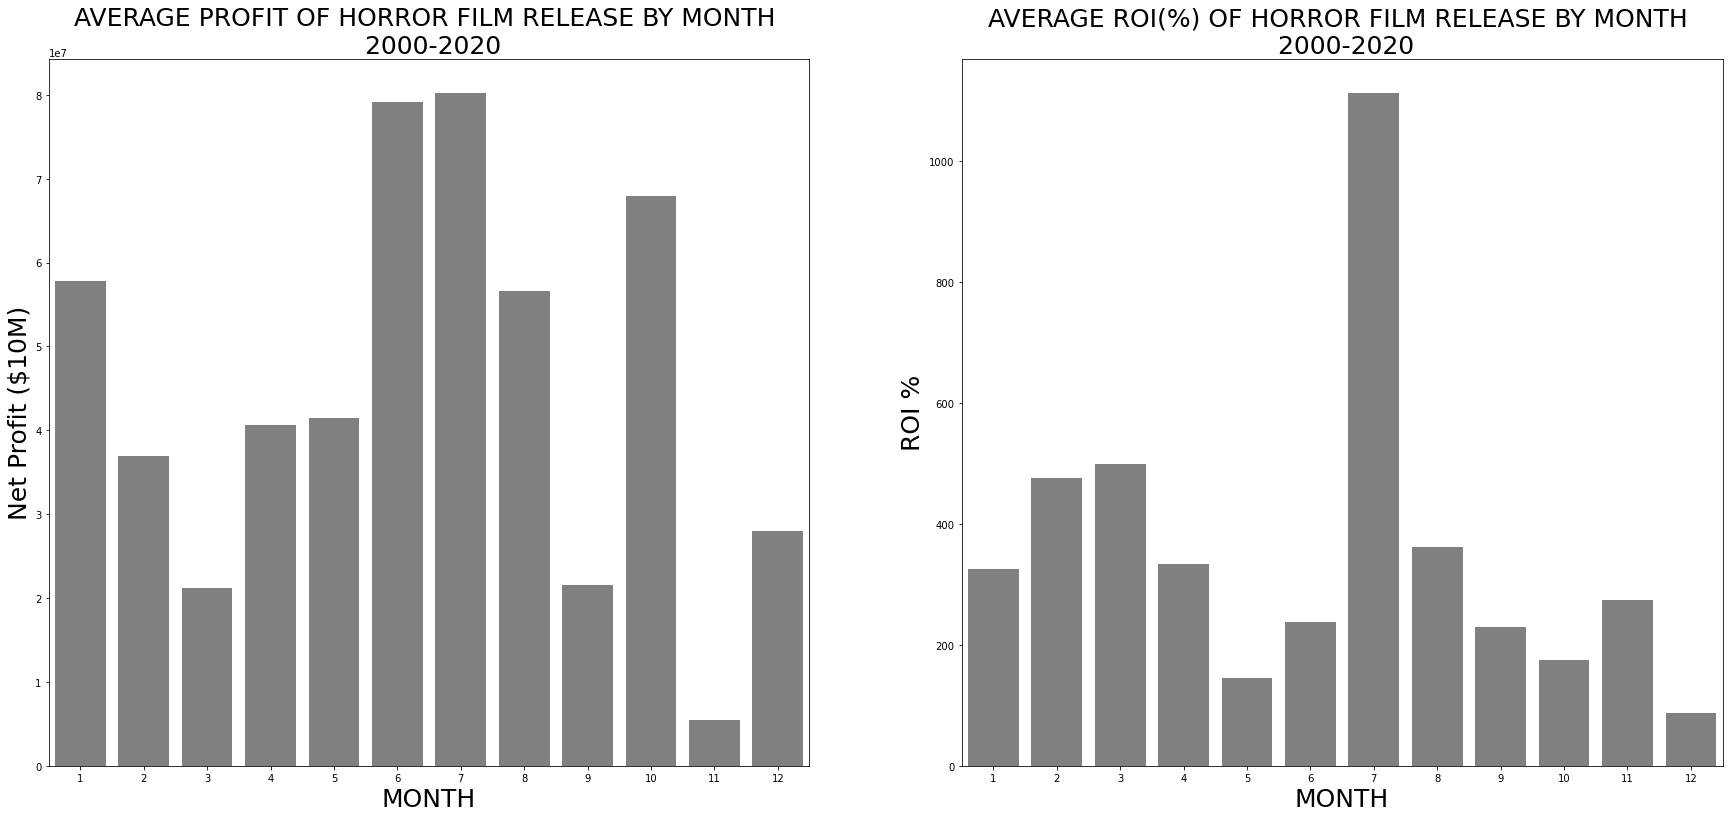

In [23]:
# Graph a barplot with months on the x axis and median profit margin/ROI amount on the y axis
fig, axs = plt.subplots(figsize=(30,13), ncols=2)

sns.barplot(x=month_horror, y=profit_amount_horror, ax=axs[0], color='grey')
sns.barplot(x=month_horror, y=ROI_horror, ax=axs[1], color='grey')

axs[0].set_xlabel('MONTH', fontsize=25)
axs[0].set_ylabel('Net Profit ($10M)', fontsize=25)
axs[0].set_title(label='AVERAGE PROFIT OF HORROR FILM RELEASE BY MONTH \n 2000-2020', fontsize=25)

axs[1].set_xlabel('MONTH', fontsize=25)
axs[1].set_ylabel('ROI %', fontsize=25)
axs[1].set_title(label='AVERAGE ROI(%) OF HORROR FILM RELEASE BY MONTH \n 2000-2020', fontsize=25);

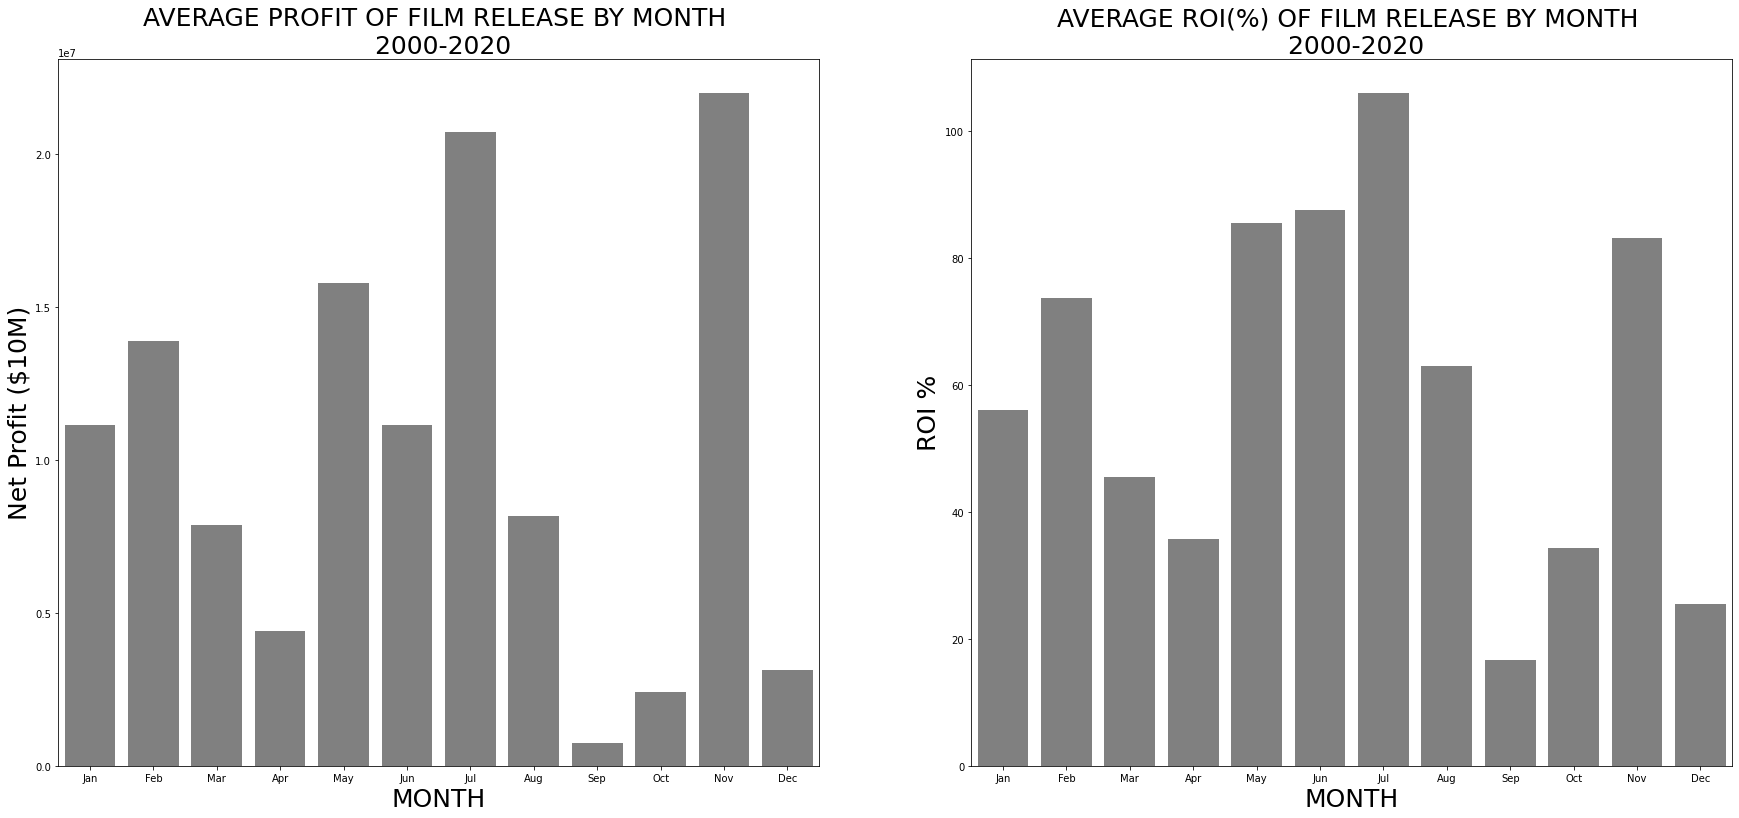

In [24]:
fig, axs = plt.subplots(figsize=(30,13), ncols=2)

sns.barplot(x=month, y=profit_amount, ax=axs[0], color='grey')
sns.barplot(x=month, y=ROI, ax=axs[1], color='grey')
sns.set_context('poster')

axs[0].set_xlabel('MONTH', fontsize=25)
axs[0].set_ylabel('Net Profit ($10M)', fontsize=25)
axs[0].set_title(label='AVERAGE PROFIT OF FILM RELEASE BY MONTH \n 2000-2020', fontsize=25)

axs[1].set_xlabel('MONTH', fontsize=25)
axs[1].set_ylabel('ROI %', fontsize=25)
axs[1].set_title(label='AVERAGE ROI(%) OF FILM RELEASE BY MONTH \n 2000-2020', fontsize=25);

### Film Genres Frequently Released

The graph shows the total frequency of releases by genre for each film over the years 2000 - 2020 from The Numbers and TMDb datasets. 

Given the frequency of the genres released tells a few things:
 - what genres other studio are typically releasing
 - how competitive the genres are

It is worth considering what genres our competitors are releasing often. For example, drama movies are released the most, so Microsoft would have to release a drama film that sets it apart from the others.

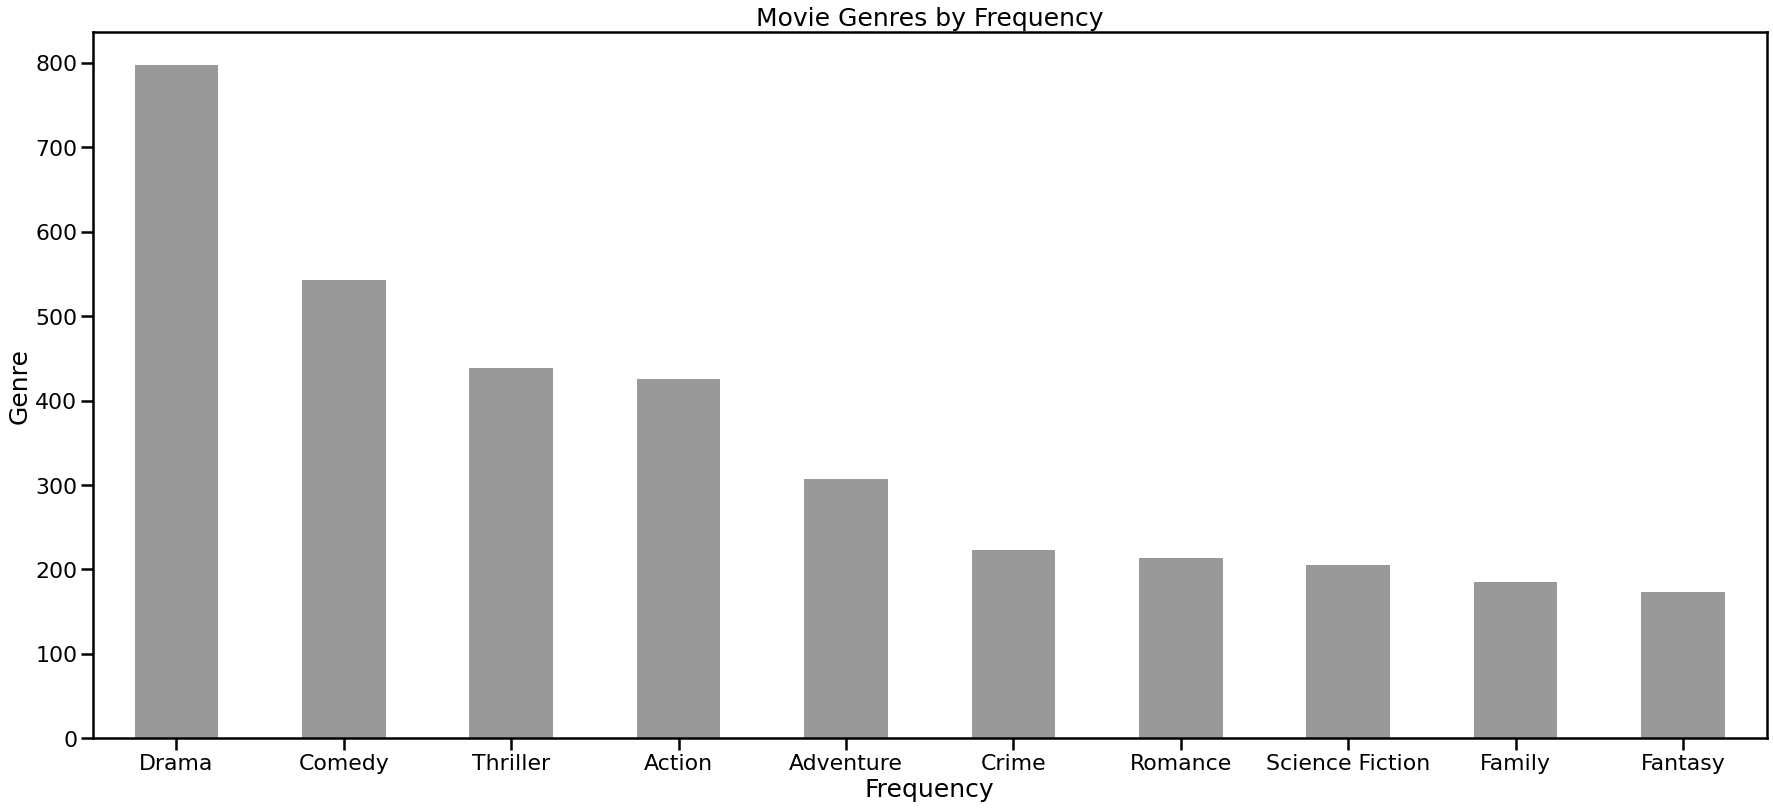

In [25]:
fig, ax = plt.subplots(figsize=(30,13))

genre_overall['genre_name'].value_counts()[:10].plot(kind='bar', color='#999999')
plt.xticks(rotation=0)
ax.set_xlabel('Frequency', fontsize=25)
ax.set_ylabel('Genre', fontsize=25)
ax.set_title('Movie Genres by Frequency', fontsize=25);

### Return on Investment (ROI) by Genres

We can see that horror films have an extremely high ROI while music and science fiction have the lowest returns. The graph shows the mean return on investment (in percent) for each film genre over the years 2000-2020 from the The Numbers and TMDb datasets. 

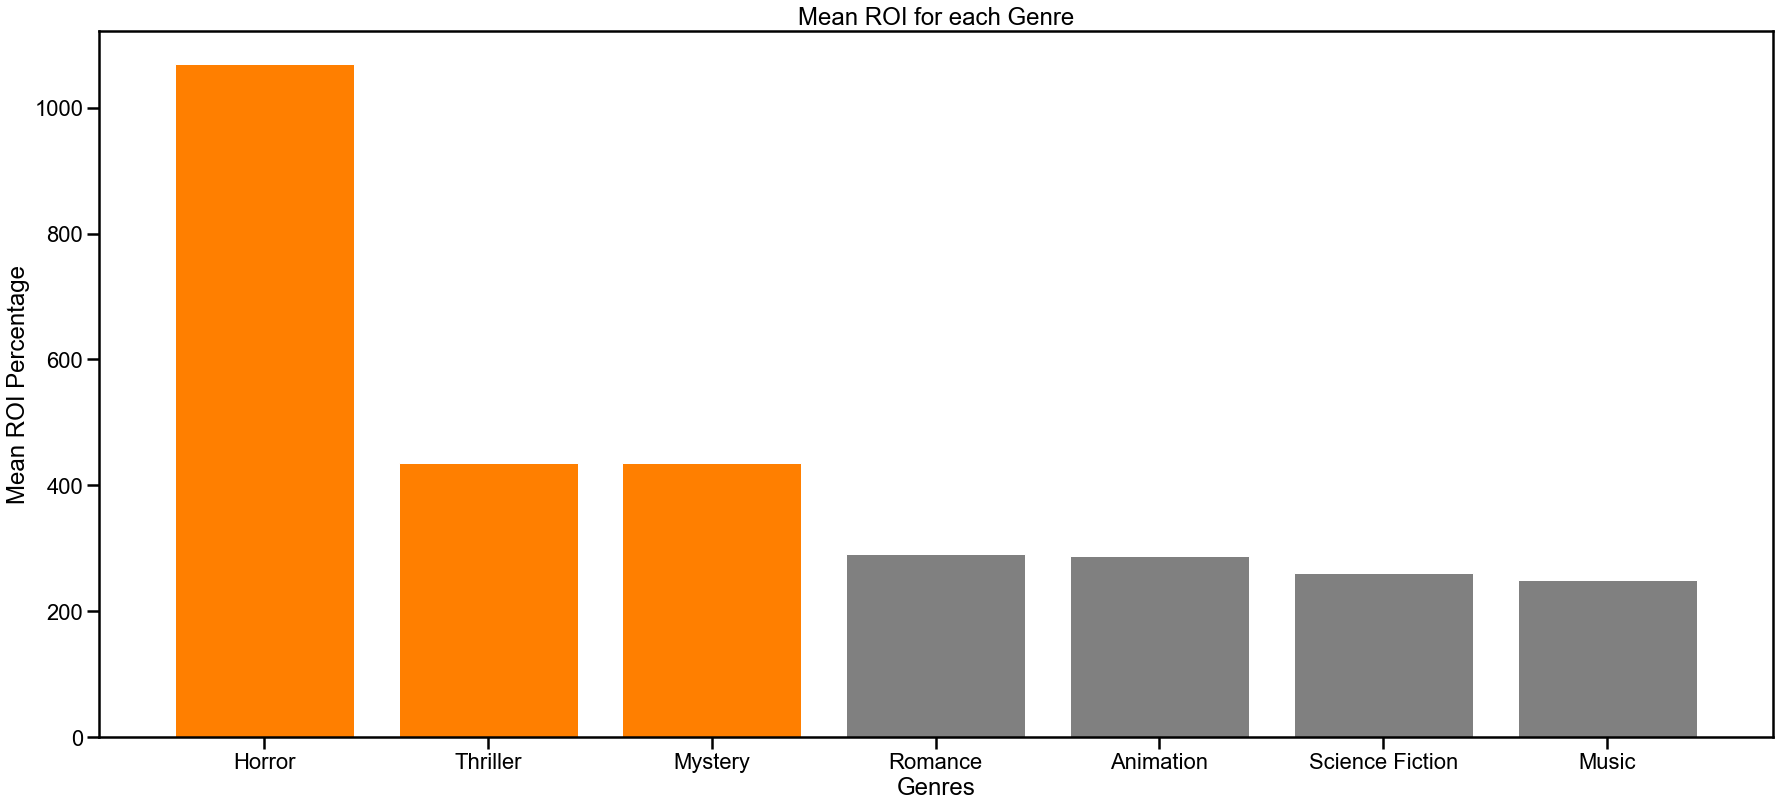

In [26]:
fig, ax= plt.subplots(figsize=(30,13))


sns.set(font_scale=2)
ax.bar(genre_groups.index, 'ROI_perc', data=genre_groups, color=['#ff7f00', '#ff7f00', '#ff7f00', 'grey', 'grey', 'grey', 'grey'])
ax.set_title("Mean ROI for each Genre")
ax.set_xlabel("Genres")
ax.set_ylabel("Mean ROI Percentage");

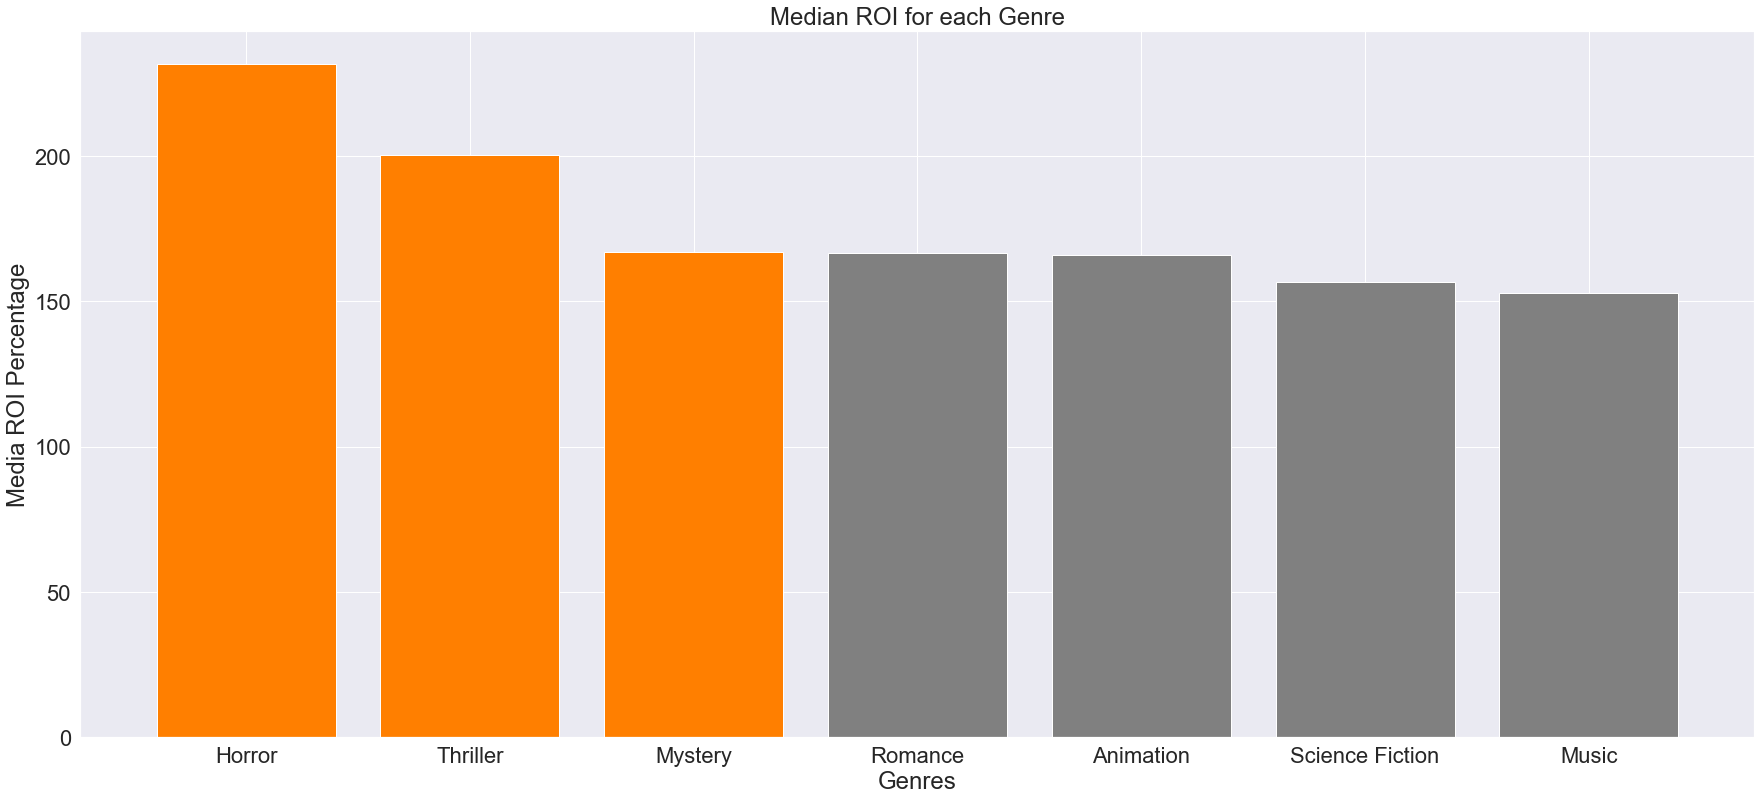

In [27]:
fig, ax= plt.subplots(figsize=(30,13))


sns.set(font_scale=2)
ax.bar(genre_groups.index, 'ROI_perc', data=genre_groups_med, color=['#ff7f00', '#ff7f00', '#ff7f00', 'grey', 'grey', 'grey', 'grey'] )
ax.set_title("Median ROI for each Genre")
ax.set_xlabel("Genres")
ax.set_ylabel("Media ROI Percentage");

## Conclusions

This analysis leads to three recommendations for Microsoft when creating a movie studio:

- __Release movies during the months May, Jun, July, and November.__ This when most of the top studios are releasing their films and when people are most likely to go to the theater to see these movies.
- __Create horror movies or impressive films in other genres.__ Making horror films as a part of the production portfolio would garner Microsoft a higher return on investment, meaning a higher profit based on how much is spent on the movie. However, if Microsoft decided to make a film in another genre such as drama, the movie would have to really set itself apart from a sea of competition.

### Next Steps

Further analyses could provide additional insights to having a more successful movie studio for Microsoft:

- __Net Profit to Studio Data.__ As of now we are seeing the net profit of the film at box office but not what profits are returning directly to the studios involved. Having the net profit by film to studio would increase the strength of our analysis of when to release movies.